**BERT** stands for Bidirectional Encoder Representations from Transformers. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing).

The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a **BERT** model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster. 

In [1]:
import torch
import os

import numpy as np
import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

### Load the Disaster Tweets

Interesting method from pandas to check memory that pandas dataframes are using.

In [3]:
df_train = pd.read_csv("kaggle-datasets/train.csv")
df_test = pd.read_csv("kaggle-datasets/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [4]:
df_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df_train['keyword'].nunique()

221

In [23]:
df_test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Explore the dataset

In [24]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

In [25]:
print("Train Length Stat")
print(df_train["length"].describe())

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64
Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


### Preprocess the data

In [26]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = len(df_train)  # Assuming df_train is your dataset as a pandas DataFrame
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2  # Note: This might be unused in PyTorch setup directly but can guide dataset split

STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES * TRAIN_SPLIT) // BATCH_SIZE

EPOCHS = 2

In [37]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

### Load a DistilBERT model from pytorch

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters (paper).

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In [28]:
# Load the tokenizer and model from the transformer's library
preset = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(preset) 

# Load the DistilBERT model and tokenizer suitable for classification tasks.
# In PyTorch, preprocessing and model loading are handled separately,
# with the tokenizer taking care of preprocessing.

In [29]:
# Specify the sequence length
sequence_length = 160

In [30]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model.parameters

<bound method Module.parameters of DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dr

In [38]:
X_train = X_train.tolist()  
X_val = X_val.tolist()  

y_train = y_train.tolist()
y_val = y_val.tolist()

In [39]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)

In [43]:
type(train_encodings.keys())

dict_keys

### Train my own model, fine-tuning DistilBERT

In [47]:
from torch.utils.data import DataLoader, TensorDataset

questions:
- differences between TensorDataset and DataLoader
- hyperparameters: ? do we want to optimize those during the fine-tuning step
- be sure about how to chose drop-out values 
- understand the challenges in optimizing every kind of architecture

In [52]:
# Tokenize training data
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)

# Convert labels and encodings to PyTorch datasets
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(y_val))

# Create DataLoaders
batch_size = BATCH_SIZE  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Load the DistilBert model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Specify loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Move model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
epochs = EPOCHS  # Make sure EPOCHS is defined
for epoch in range(epochs):
    model.train()
    total_loss, total_accuracy = 0, 0
    
    # Training
    for batch in train_loader:
        batch = [r.to(device) for r in batch]
        inputs, labels = batch
        model.zero_grad()
        
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs} | Loss: {avg_train_loss}')
    
    # Validation
    model.eval()
    total_eval_accuracy = 0
    for batch in val_loader:
        batch = [r.to(device) for r in batch]
        inputs, labels = batch
        
        with torch.no_grad():
            outputs = model(inputs, labels=labels)
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = (predictions == labels).cpu().numpy().mean() * 100
        total_eval_accuracy += accuracy

    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print(f'Epoch {epoch+1}/{epochs} | Validation Accuracy: {avg_val_accuracy}%')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/2 | Loss: 0.4881198807224553
Epoch 1/2 | Validation Accuracy: 80.42077850877193%
Epoch 2/2 | Loss: 0.3720952146028349
Epoch 2/2 | Validation Accuracy: 83.48067434210526%


In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [78]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

In [61]:
model.eval()  # Put the model in evaluation mode

# Initialize a list to store batch predictions
all_predictions = []

for i,batch in enumerate(train_loader):
    batch = [r.to(device) for r in batch]
    inputs, labels = batch
    
    print(i)
    
    with torch.no_grad():  # Disable gradient calculations
        outputs = model(inputs, labels=labels)  # Forward pass
        
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    
    # Append current batch predictions to the list
    all_predictions.append(predictions)

# Concatenate all batch predictions into a single vector
# Note: You might need to use predictions.cpu() before concatenation if you're using a GPU
y_pred = torch.cat(all_predictions, dim=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190


In [63]:
len(y_train), len(y_pred)

(6090, 6090)

tensor(1)

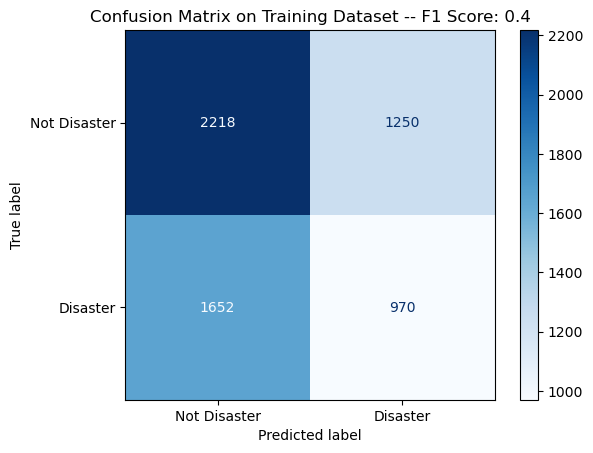

In [79]:
displayConfusionMatrix(y_train, y_pred.tolist(), "Training")